In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/the-oscar-award/the_oscar_award.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#Data cleaning
oscar=pd.read_csv('/kaggle/input/the-oscar-award/the_oscar_award.csv')
#print(oscar.info())


oscar['category']=oscar['category'].apply(lambda x:x.strip())
oscar['name']=oscar['name'].apply(lambda x:x.strip().replace("(","").replace(")",""))
oscar['film']=oscar['film'].apply(lambda x: np.NaN if str(x)=='nan' else str(x).strip())

oscar['category']=oscar['category'].apply(lambda x:x.capitalize())



category=oscar['category'].str.split('(',n=1,expand=True)
category.columns=['category1','category2']
category['category2']=category['category2'].apply(lambda x:str(x).capitalize().replace(")",""))
oscar=pd.concat([oscar,category],axis=1)
#print(oscar['name'])



nameRole=oscar['name'].str.split(',',expand=True)
nameRole=nameRole.rename(columns={0:'one_of_the_names'})
nameRole['one_of_the_names']=nameRole['one_of_the_names'].apply(lambda x: x if x.find(":")< 0 else x[x.index(':')+1:] )

oscar=pd.concat([oscar,nameRole['one_of_the_names']],axis=1)

In [4]:
print(oscar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10395 entries, 0 to 10394
Data columns (total 10 columns):
year_film           10395 non-null int64
year_ceremony       10395 non-null int64
ceremony            10395 non-null int64
category            10395 non-null object
name                10395 non-null object
film                10091 non-null object
winner              10395 non-null bool
category1           10395 non-null object
category2           10395 non-null object
one_of_the_names    10395 non-null object
dtypes: bool(1), int64(3), object(6)
memory usage: 741.2+ KB
None


In [5]:
print(oscar.head(10))

   year_film  year_ceremony  ceremony        category  \
0       1927           1928         1           Actor   
1       1927           1928         1           Actor   
2       1927           1928         1         Actress   
3       1927           1928         1         Actress   
4       1927           1928         1         Actress   
5       1927           1928         1   Art direction   
6       1927           1928         1   Art direction   
7       1927           1928         1   Art direction   
8       1927           1928         1  Cinematography   
9       1927           1928         1  Cinematography   

                      name               film  winner       category1  \
0      Richard Barthelmess          The Noose   False           Actor   
1            Emil Jannings   The Last Command    True           Actor   
2           Louise Dresser    A Ship Comes In   False         Actress   
3             Janet Gaynor         7th Heaven    True         Actress   
4      

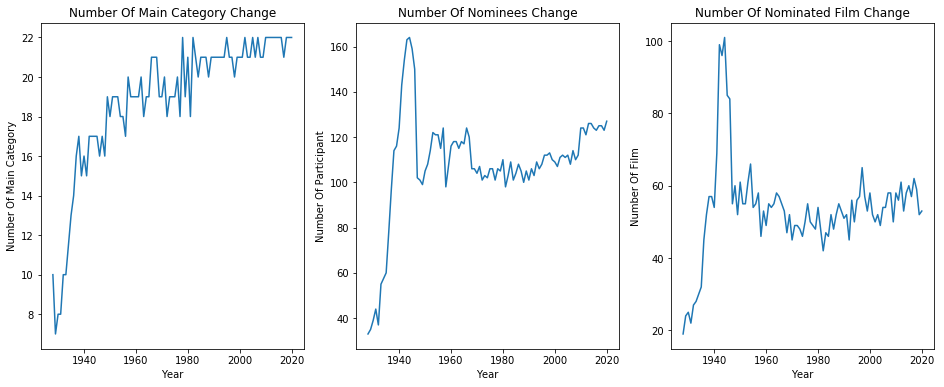

In [6]:
#Change from year to year
year_record=oscar[['year_ceremony','category1','name','film']].groupby(by='year_ceremony').nunique()
del year_record['year_ceremony']
year_record['true_winner']=oscar.loc[oscar.winner==1,['year_ceremony','winner']].groupby(by='year_ceremony').count()
year_record['false_winner']=oscar.loc[oscar.winner==0,['year_ceremony','winner']].groupby(by='year_ceremony').count()


#print(year_record.describe().round(4))

f, axes = plt.subplots(1,3, figsize=(16,6))
year_number=year_record.index.tolist()
yCategory=year_record['category1'].tolist()
yName=year_record['name'].tolist()
yFilm=year_record['film'].tolist()
vis1 = sns.lineplot(x=year_number, y=yCategory,ax=axes[0])
vis1.set(xlabel='Year', ylabel='Number Of Main Category')
axes[0].set_title('Number Of Main Category Change')
vis2 = sns.lineplot(x=year_number, y=yName,ax=axes[1])
vis2.set(xlabel='Year', ylabel='Number Of Participant')
axes[1].set_title('Number Of Nominees Change')
vis3 = sns.lineplot(x=year_number, y=yFilm,ax=axes[2])
vis3.set(xlabel='Year', ylabel='Number Of Film')
axes[2].set_title('Number Of Nominated Film Change')
plt.show()

In [7]:
#description
year_record['nominate']=oscar[['year_ceremony','winner']].groupby(by='year_ceremony').count()

yearDescr=round(year_record.describe(),4)
print(yearDescr)

       category1      name      film  true_winner  false_winner  nominate
count     92.000   92.0000   92.0000      92.0000       92.0000   92.0000
mean      18.913  108.6739   53.6304      25.6196       87.3696  112.9891
std        3.386   23.6551   13.1715       4.5400       22.7947   25.9829
min        7.000   33.0000   19.0000       7.0000       20.0000   35.0000
25%       18.000  103.7500   49.0000      25.0000       80.7500  106.7500
50%       20.000  109.5000   53.5000      26.0000       85.5000  112.0000
75%       21.000  120.2500   57.0000      28.0000       96.0000  124.0000
max       22.000  164.0000  101.0000      33.0000      156.0000  186.0000


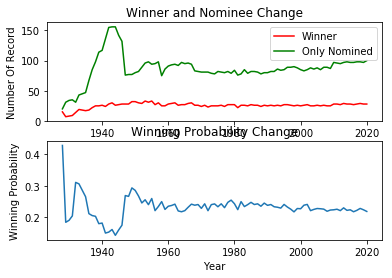

In [8]:
#Change in award-winning rate per year
plt.subplot(2,1,1)
true_winner_line,false_winner_line=plt.plot(
    year_number,year_record['true_winner'].to_list(),
    year_number,year_record['false_winner'].to_list())


plt.setp(true_winner_line,color='r')
plt.setp(false_winner_line,color='g')
plt.ylabel('Number Of Record')
plt.xlabel('Year')
plt.title('Winner and Nominee Change')

plt.legend(handles = [true_winner_line,false_winner_line], labels = ['Winner', 'Only Nomined'], loc = 'best')


year_record['winning_probability']=year_record['true_winner']/year_record['nominate']
yWinning_probability=year_record['winning_probability'].to_list()
vis1 = sns.lineplot(x=year_number, y=yWinning_probability,ax=plt.subplot(2,1,2))
vis1.set(xlabel='Year', ylabel='Winning Probability')
vis1.set_title('Winning Probability Change')

plt.show()

In [9]:
#Film information
All_movie=oscar[['film','winner']].groupby(by='film').sum().sort_values(by='winner',ascending=False)
All_movie['Awards']=All_movie['winner'].apply(lambda x:int(x))
del All_movie['winner']
All_movie['Nominations']=oscar[['film','winner']].groupby(by='film').count()
All_movie['Winnin_rate']=All_movie['Awards']/All_movie['Nominations']

print(All_movie.head(10))

                                               Awards  Nominations  \
film                                                                 
Titanic                                            12           16   
The Lord of the Rings: The Return of the King      11           11   
Ben-Hur                                            11           12   
West Side Story                                    10           11   
The English Patient                                 9           12   
Gigi                                                9            9   
The Last Emperor                                    9            9   
Slumdog Millionaire                                 8           10   
On the Waterfront                                   8           12   
My Fair Lady                                        8           12   

                                               Winnin_rate  
film                                                        
Titanic                              

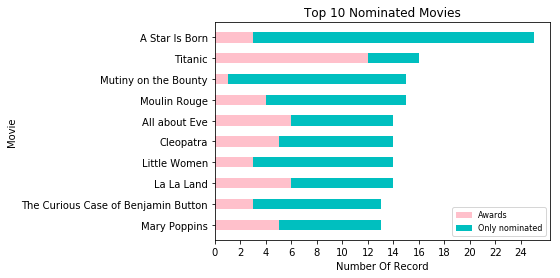

In [10]:
#Top 10 Nominated Movies
nominated_movie=All_movie.sort_values(by='Nominations',ascending=False).head(10)
nominated_movie['Diff']=nominated_movie['Nominations']-nominated_movie['Awards']
nominated_movie=nominated_movie.sort_values(by='Nominations')
vis1=plt.barh(nominated_movie.index.tolist(), nominated_movie['Awards'], 0.5,color = 'pink', label = 'Awards')
vis1=plt.barh(nominated_movie.index.tolist(), nominated_movie['Diff'],0.5, color = 'c', left = nominated_movie['Awards'], label = 'Only nominated')

plt.xlabel('Number Of Record')
plt.ylabel('Movie')

plt.xticks(range(0,max(nominated_movie['Nominations']),2))
plt.legend(loc='lower right',fontsize=8)
plt.title('Top 10 Nominated Movies')

plt.show()

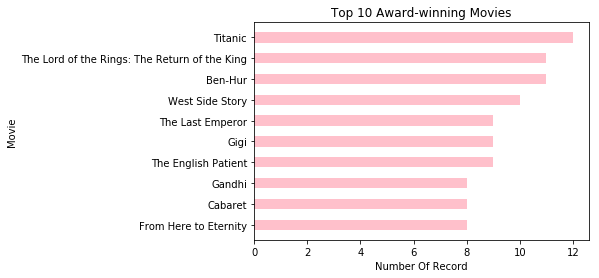

In [11]:
#Top 10 Award-winning Movies
Award_winning_movie=All_movie.sort_values(by='Awards',ascending=False).head(10)
Award_winning_movie=Award_winning_movie.sort_values(by='Awards')
movie_name=Award_winning_movie.index.tolist()

count_award=Award_winning_movie['Awards'].to_list()


vis2= plt.barh(movie_name,count_award,height=0.5, color = 'pink')
plt.xlabel('Number Of Record')
plt.ylabel('Movie')
plt.title('Top 10 Award-winning Movies')
plt.xticks(range(0,max(Award_winning_movie['Awards'])+2,2))
plt.show()

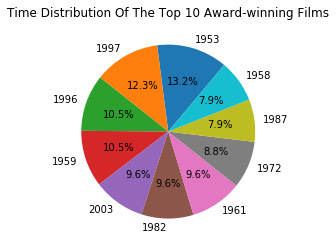

In [12]:
#Time Distribution Of The Top 10 Award-winning Films
topTenMovieInfo=oscar.loc[oscar['film'].isin(movie_name),['year_ceremony','year_film','name','film','category1']]


plt.pie(topTenMovieInfo.year_film.value_counts(),labels=topTenMovieInfo.year_film.value_counts().index,
        autopct='%1.1f%%',shadow=False,startangle=50)

plt.title('Time Distribution Of The Top 10 Award-winning Films')

plt.show()

In [13]:
#winner infomation
nominated_person=oscar['one_of_the_names'].value_counts()
nominated_person=pd.DataFrame(nominated_person)

nominated_person['Awards']=oscar.loc[oscar.winner==1,['one_of_the_names','winner']].groupby(by='one_of_the_names').count()

print(nominated_person.head(10))

                                             one_of_the_names  Awards
Metro-Goldwyn-Mayer                                        64    12.0
Walt Disney                                                61    24.0
Warner Bros.                                               44     8.0
John Williams                                              44     4.0
Alfred Newman                                              41     9.0
France                                                     37     9.0
Edith Head                                                 34     8.0
  Cedric Gibbons                                           28     8.0
Metro-Goldwyn-Mayer Studio Sound Department                27     8.0
Italy                                                      27    10.0


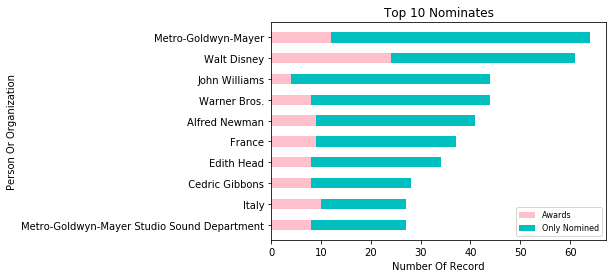

In [14]:
#Top 10 Nominates
topTenPerson=nominated_person.head(10)
topTenPerson=pd.DataFrame(topTenPerson)
topTenPerson=topTenPerson.sort_values(by='one_of_the_names')

topTenPerson=topTenPerson.rename(columns={'one_of_the_names':'Total nominations'})

topTenPerson['Awards']=oscar.loc[oscar.winner==1,['one_of_the_names','winner']].groupby(by='one_of_the_names').count()
topTenPerson['Only Nomined']=topTenPerson['Total nominations']-topTenPerson['Awards']

vis1= plt.barh(topTenPerson.index.tolist(),topTenPerson['Awards'].to_list(),height=0.5, color = 'pink',label='Awards')
vis1= plt.barh(topTenPerson.index.tolist(),topTenPerson['Only Nomined'].to_list(),height=0.5, left=topTenPerson['Awards'].to_list(),color = 'c',label='Only Nomined')
plt.xlabel('Number Of Record')
plt.ylabel('Person Or Organization')
plt.title('Top 10 Nominates')
plt.legend(loc='lower right',fontsize=8)

plt.show()

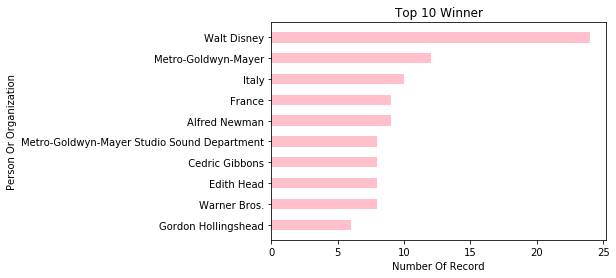

In [15]:
#Top 10 Winner
topTenAwardsP=nominated_person.sort_values(by='Awards',ascending=False).head(10)
topTenAwardsP=topTenAwardsP.sort_values(by='Awards')
#print(topTenAwardsP)
person_name=topTenAwardsP.index.tolist()

count_award=topTenAwardsP['Awards'].to_list()


vis2= plt.barh(person_name,count_award,height=0.5, color = 'pink')
plt.xlabel('Number Of Record')
plt.ylabel('Person Or Organization')
plt.title('Top 10 Winner')
#plt.xticks(range(0,int(max(topTenAwardsP['Awards']))+2))

plt.show()